In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:
1. Can leverage existing neural network architeture proven to work on problems similar to our
2. Can everage a working network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [34]:
!nvidia smi

/bin/bash: nvidia: command not found


## Downloading and becoming one with the data

In [35]:
# Get data(10% of 10 food classes from Food101)
import zipfile

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

zip = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip.extractall()
zip.close()

--2023-07-04 20:52:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   217MB/s    in 0.7s    

2023-07-04 20:52:31 (217 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [36]:
# How many images in each folder?

import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirname, filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} files in the path {dirpath}")

There are 3 directories and 0 files in the path 10_food_classes_10_percent
There are 10 directories and 0 files in the path 10_food_classes_10_percent/train
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/steak
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 files in the path 10_food_classes_10_percent/train/chicken_wings
There are 0 d

## Crating data loader(preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [37]:
# data directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup data inputs

train_datagen = ImageDataGenerator(rescale = 1/225.)
test_datagen = ImageDataGenerator(rescale = 1/225.)

print("Training images: ")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          batch_size = BATCH_SIZE,
                                                          target_size = IMAGE_SHAPE,
                                                          class_mode = "categorical")

print("Test images: ")

test_data = test_datagen.flow_from_directory(test_dir,
                                                        batch_size = BATCH_SIZE ,
                                                        target_size = IMAGE_SHAPE,
                                                        class_mode = "categorical")

Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks( things to urn whilst our model trains)

Callbacks are extra functionality you can add to you r models to be performed durning or after training. Some of the most popular callbacks:
* Tracking experiments with TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model form training (before it trains too long and overfites) with the EarlyStopping callback

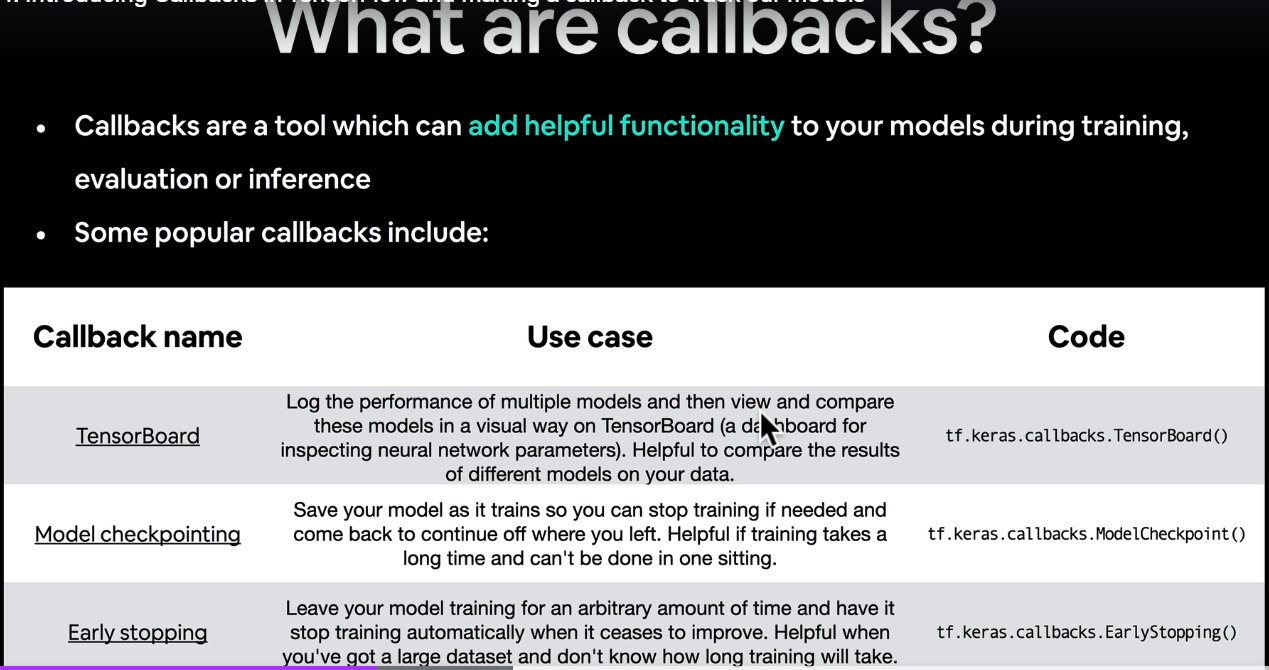

In [39]:
# Crate TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow hub

In [40]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [41]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [42]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url(str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes , default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature ectractor
    layer and Dense output layers with num_classes output neurons.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable= False,# freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3, ))
  # Create our sequential model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model


In [43]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)


In [44]:
train_data_10_percent.num_classes

10

In [45]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [46]:
# compile our resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch = len(train_data_10_percent),
                 callbacks = [create_tensorboard_callback("tensorflow_hub", "resnet50V2")],
                 validation_data = test_data,
                 validation_steps = len(test_data))

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230704-205235
Epoch 1/5
24/24 [==============================] - 31s 1s/step - loss: 1.9108 - accuracy: 0.3667 - val_loss: 1.2068 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 19s 811ms/step - loss: 0.8879 - accuracy: 0.7413 - val_loss: 0.8651 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 18s 779ms/step - loss: 0.6160 - accuracy: 0.8187 - val_loss: 0.7637 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4656 - accuracy: 0.8827 - val_loss: 0.7149 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.3672 - accuracy: 0.9187 - val_loss: 0.6845 - val_accuracy: 0.7780


In [68]:
def plot_loss_curves(history = resnet_history):
  """
  Takes the history of the model and plots the train and validation loss and accuracy
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  plt.plot(epochs, loss, label = "training loss")
  plt.plot(epochs, val_loss, label = "validation loss")
  plt.title("loss_curves")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(epochs,accuracy, label = "training accuracy")
  plt.plot(epochs, val_acc, label = "validation accuracy")
  plt.title("loss_curves")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()

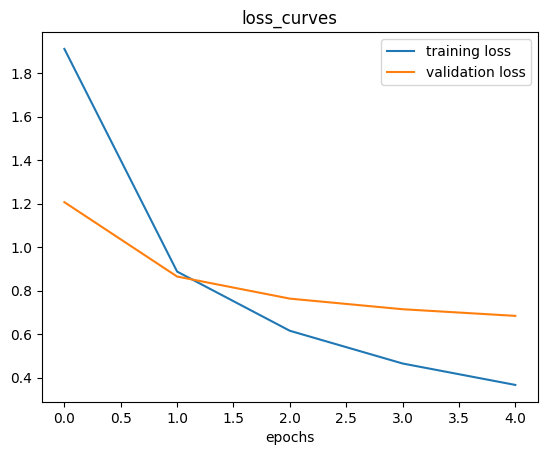

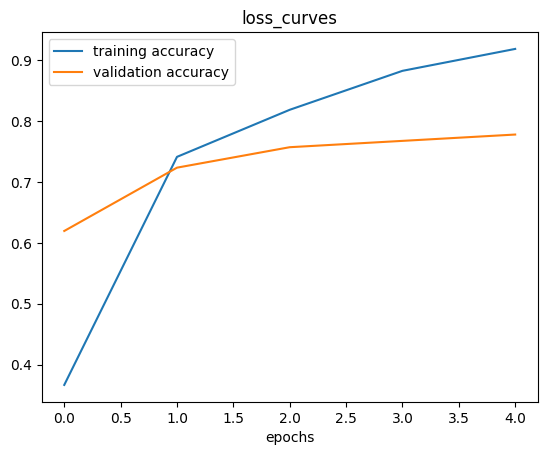

In [69]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow HUb Feature Extraction model

In [74]:
efficientnet_model = create_model(model_url = efficientnet_url)

In [75]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [76]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [81]:
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = "Adam",
                           metrics = ["accuracy"])

efficient_history = efficientnet_model.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230704-213440
Epoch 1/5
24/24 [==============================] - 28s 1s/step - loss: 1.7197 - accuracy: 0.5067 - val_loss: 1.2270 - val_accuracy: 0.7424
Epoch 2/5
24/24 [==============================] - 18s 766ms/step - loss: 1.0371 - accuracy: 0.7760 - val_loss: 0.8557 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 18s 768ms/step - loss: 0.7608 - accuracy: 0.8320 - val_loss: 0.7022 - val_accuracy: 0.8332
Epoch 4/5
24/24 [==============================] - 19s 826ms/step - loss: 0.6168 - accuracy: 0.8600 - val_loss: 0.6240 - val_accuracy: 0.8452
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5249 - accuracy: 0.8787 - val_loss: 0.5738 - val_accuracy: 0.8552


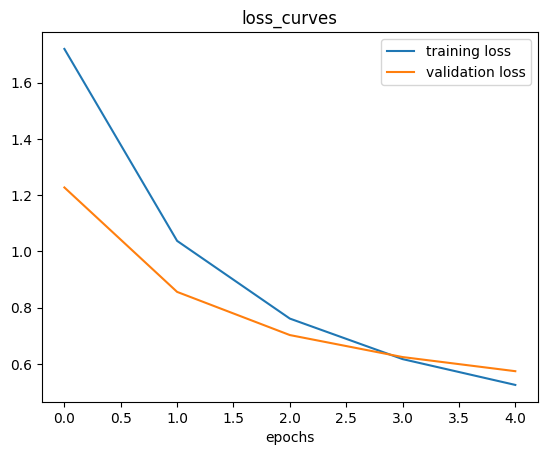

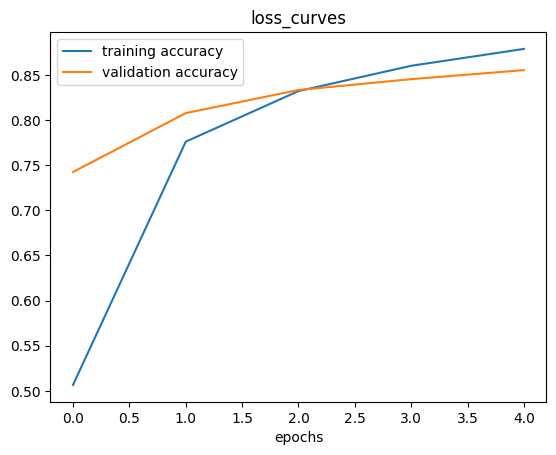

In [82]:
plot_loss_curves(efficient_history)

## Comparing different types of models using tensorboard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So, if you're running private expeiments(things you don't want others to see) do not upload them to TensorBoard.dev.

In [84]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data"\
--one_shot

2023-07-04 21:58:08.670513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   RRZB-PPLG



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

In [86]:
# list all experiments
!tensorboard dev list

2023-07-04 22:05:48.819098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/63SzNf54TkewIBcxkDaUpw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   63SzNf54TkewIBcxkDaUpw
	Created              2023-07-04 22:00:02 (5 minutes ago)
	Updated              2023-07-04 22:00:08 (5 minutes ago)
	Runs                 11
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  15084806
Total: 1 experiment(s)


In [87]:
# delete an experiment
!tensorboard dev delete --experiment_id 63SzNf54TkewIBcxkDaUpw

2023-07-04 22:07:23.947733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 63SzNf54TkewIBcxkDaUpw.


In [88]:
!tensorboard dev list

2023-07-04 22:07:40.882664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.
